#  TikTok Machine Learning Model for Classification of videos

### Author: Khulekani Mgenge

In [ ]:
 # Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import packages for data preprocessing
from sklearn.feature_extraction.text import CountVectorizer


# Import packages for data modeling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,accuracy_score,precision_score,recall_score,\
f1_score,confusion_matrix,ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier
import xgboost 
#from xgboost import XGBClassifier
from xgboost import plot_importance


In [11]:
#Load dataset into dataframe
df = pd.read_csv('tiktok_dataset.csv')

In [12]:
#Display first 5 rows
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0


In [13]:
# Getting number of rows,columns and basic information

print("Data Shape: ",df.shape)
print('')
df.info()

Data Shape:  (19382, 12)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19382 entries, 0 to 19381
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   #                         19382 non-null  int64  
 1   claim_status              19084 non-null  object 
 2   video_id                  19382 non-null  int64  
 3   video_duration_sec        19382 non-null  int64  
 4   video_transcription_text  19084 non-null  object 
 5   verified_status           19382 non-null  object 
 6   author_ban_status         19382 non-null  object 
 7   video_view_count          19084 non-null  float64
 8   video_like_count          19084 non-null  float64
 9   video_share_count         19084 non-null  float64
 10  video_download_count      19084 non-null  float64
 11  video_comment_count       19084 non-null  float64
dtypes: float64(5), int64(3), object(4)
memory usage: 1.8+ MB


In [14]:
#Check for missing values
df.isna().sum()

#                             0
claim_status                298
video_id                      0
video_duration_sec            0
video_transcription_text    298
verified_status               0
author_ban_status             0
video_view_count            298
video_like_count            298
video_share_count           298
video_download_count        298
video_comment_count         298
dtype: int64

In [15]:
# Drop rows with missing values
df = df.dropna(axis=0)

In [16]:
# Check for duplicates
df.duplicated().sum()

0

In [18]:
# Check class balance
df["claim_status"].value_counts(normalize=True)

claim      0.503458
opinion    0.496542
Name: claim_status, dtype: float64

In [19]:
#Creating 'text_length' column
df['text_length'] = df['video_transcription_text'].str.len()
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,verified_status,author_ban_status,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length
0,1,claim,7017666017,59,someone shared with me that drone deliveries a...,not verified,under review,343296.0,19425.0,241.0,1.0,0.0,97
1,2,claim,4014381136,32,someone shared with me that there are more mic...,not verified,active,140877.0,77355.0,19034.0,1161.0,684.0,107
2,3,claim,9859838091,31,someone shared with me that american industria...,not verified,active,902185.0,97690.0,2858.0,833.0,329.0,137
3,4,claim,1866847991,25,someone shared with me that the metro of st. p...,not verified,active,437506.0,239954.0,34812.0,1234.0,584.0,131
4,5,claim,7105231098,19,someone shared with me that the number of busi...,not verified,active,56167.0,34987.0,4110.0,547.0,152.0,128


In [20]:
#Calculating the average 'text_length' for claims and opinions
df[['claim_status','text_length']].groupby('claim_status').mean()

,text_length
claim_status,
claim,95.376978
opinion,82.722562


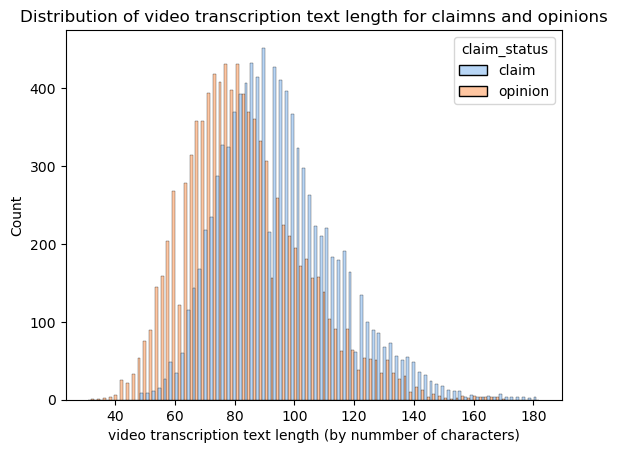

In [21]:
#Visualize the distrbution of 'text_length' for claims and opinions using a histogram
sns.histplot(data=df, stat='count', multiple='dodge', x='text_length', kde=False, palette='pastel',
            hue='claim_status', element='bars',legend=True)
plt.xlabel("video transcription text length (by nummber of characters)")
plt.ylabel("Count")
plt.title("Distribution of video transcription text length for claimns and opinions")

plt.show()

In [23]:
# Encode target variable
df['claim_status'] = df['claim_status'].map({'claim': 1, 'opinion': 0})

In [25]:
#Encode categorical variables
df = pd.get_dummies(df,columns=['verified_status','author_ban_status'], drop_first=True)
df.head()

,#,claim_status,video_id,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,1,7017666017,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,2,1,4014381136,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,3,1,9859838091,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0
3,4,1,1866847991,25,someone shared with me that the metro of st. p...,437506.0,239954.0,34812.0,1234.0,584.0,131,0,0,0
4,5,1,7105231098,19,someone shared with me that the number of busi...,56167.0,34987.0,4110.0,547.0,152.0,128,0,0,0


,#,claim_status,video_id,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,1,1,7017666017,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1


In [28]:
#Isolate target variable and features
y = df['claim_status']
X = df.copy()
X = X.drop(['claim_status','#','video_id'], axis=1)

In [29]:
X.head(3)

,video_duration_sec,video_transcription_text,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review
0,59,someone shared with me that drone deliveries a...,343296.0,19425.0,241.0,1.0,0.0,97,0,0,1
1,32,someone shared with me that there are more mic...,140877.0,77355.0,19034.0,1161.0,684.0,107,0,0,0
2,31,someone shared with me that american industria...,902185.0,97690.0,2858.0,833.0,329.0,137,0,0,0


In [38]:
# Splitting data into training and test set. Using 80/20 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

In [39]:
#Splitting the training into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.25, random_state=0)

In [40]:
#Getting the shape of each training, validation, and test set
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((11450, 11), (3817, 11), (3817, 11), (11450,), (3817,), (3817,))

In [44]:
#Setting up a 'CountVectorizer' object, which converts a collection of text to a matrix of token counts
count_vec = CountVectorizer(ngram_range=(2, 3),
                           max_features=15,
                           stop_words='english')
count_vec

CountVectorizer(max_features=15, ngram_range=(2, 3), stop_words='english')

In [46]:
# Extract numerical features from 'video_transcription_text' in the training set
count_data = count_vec.fit_transform(X_train['video_transcription_text']).toarray()
count_data

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [47]:
#Place the numerical features from 'video_transcription_text' from training set into dataframe
count_df = pd.DataFrame(data=count_data, columns=count_vec.get_feature_names_out())

# Display first 5 rows
count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
#Extract numerical features from 'video_transcription_text' in the testing set
validation_count_data = count_vec.transform(X_val['video_transcription_text']).toarray()
validation_count_data

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [50]:
# Place numerical representation of 'video_transcription_text' from validation set into a dataframe
validation_count_df = pd.DataFrame(data=validation_count_data, columns=count_vec.get_feature_names_out())
validation_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [51]:
#Extract numerical features from 'video_transcription_text' in the testing set
test_count_data = count_vec.transform(X_test['video_transcription_text']).toarray()

# Place numerical representation of 'video_transcription_text' from validation set into a dataframe
test_count_df = pd.DataFrame(data=test_count_data, columns=count_vec.get_feature_names_out())
test_count_df.head()

,colleague discovered,colleague learned,colleague read,discovered news,discussion board,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
# Concatenate 'X_train' and 'count_df' to form the final dataframe for training data
X_train_final = pd.concat([X_train.drop(columns=['video_transcription_text']).reset_index(drop=True), count_df], axis=1)

X_train_final.head(3)

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,51,2487.0,310.0,20.0,1.0,0.0,134,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,43,118512.0,3543.0,374.0,70.0,29.0,97,0,1,0,...,0,1,0,0,0,0,0,0,0,0
2,22,105902.0,1885.0,229.0,39.0,9.0,76,0,0,1,...,0,1,0,0,0,0,0,0,0,0


In [53]:
# Concatenate 'X_val' and 'validation_count_df' to form the final dataframe for training data
X_val_final = pd.concat([X_val.drop(columns=['video_transcription_text']).reset_index(drop=True), validation_count_df], axis=1)

X_val_final.head(3)

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,11,578891.0,379596.0,14612.0,6591.0,44.0,72,0,0,1,...,0,0,0,0,0,0,0,1,0,0
1,24,6255.0,1709.0,311.0,13.0,1.0,96,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,35,410356.0,249714.0,26235.0,2060.0,1252.0,88,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [54]:
# Concatenate 'X_train' and 'count_df' to form the final dataframe for training data
X_test_final = pd.concat([X_test.drop(columns=['video_transcription_text']).reset_index(drop=True), test_count_df], axis=1)

X_test_final.head(3)

,video_duration_sec,video_view_count,video_like_count,video_share_count,video_download_count,video_comment_count,text_length,verified_status_verified,author_ban_status_banned,author_ban_status_under review,...,friend learned,friend read,internet forum,learned media,media claim,news claim,point view,read media,social media,willing wager
0,54,692084.0,135956.0,16591.0,622.0,312.0,107,0,0,0,...,0,0,0,1,1,0,0,0,0,0
1,37,5164.0,1858.0,36.0,17.0,1.0,69,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,39,801951.0,344163.0,57608.0,8578.0,2942.0,90,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# Starting by fitting a random forest model to the training data.
#Instantiating the random forest classifier

rf = RandomForestClassifier(random_state=0)


In [56]:
# Using cross-validation to tune the hyperparameters
#Creating a dictionary of hyperparameters to tune

cv_params = {'max_depth': [5, 7, None],
            'max_features': [0.3, 0.6],
            'max_samples': [0.7],
            'min_samples_leaf': [1,2],
            'min_samples_split': [2,3],
            'n_estimators': [75,100,200],
            }


In [57]:
# Define a dictionary of scoring metrics to capture

scoring = {'accuracy','precision','recall','f1'}


In [58]:
# Instantiate a GridSearchCV object
rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='recall')

In [60]:
%%time
rf_cv.fit(X_train_final,y_train)

CPU times: total: 10min 24s
Wall time: 10min 44s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [5, 7, None], 'max_features': [0.3, 0.6],
                         'max_samples': [0.7], 'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3],
                         'n_estimators': [75, 100, 200]},
             refit='recall', scoring={'precision', 'accuracy', 'recall', 'f1'})

Examine the best score

In [61]:
rf_cv.best_score_

0.9948228253467271

In [62]:
#Examine the best parameters
rf_cv.best_params_

{'max_depth': None,
 'max_features': 0.6,
 'max_samples': 0.7,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [73]:
# Instantaite the XGBoost Classifier
xgb = xgboost.XGBClassifier(objective='binary:logistic', random_state=0)


In [74]:
# Creating a dictionary of hyperparameters to tune
cv_params = {'max_depth': [4,8,12],
            'min_child_weight': [3, 5],
            'learning_rate': [0.01, 0.1],
            'n_estimator': [100, 200]
            }
# Defining a dictionary of scoring metrics to capture
scoring = {'accuracy','precision','recall','f1'}

# Instantaite the GridSearchCV object
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='recall')


In [75]:
%%time
xgb_cv.fit(X_train_final,y_train)


C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:16

C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:16

C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:16

C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:41:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:16

C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:160: UserWarning: [12:42:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimator" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\koole\anaconda3\Lib\site-packages\xgboost\core.py:16

CPU times: total: 2min
Wall time: 38.4 s


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1], 'max_depth': [4, 8, 12],
                         'min_child_weight': [3, 5],
                         'n_estimator': [100, 200]},
             refit='recall', scoring={'precision', 'accuracy', 'recall', 'f1'})

Examine the best score

In [76]:
xgb_cv.best_score_

0.989645054622456

Examine the best parameters

In [77]:
xgb_cv.best_params_

{'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 5,
 'n_estimator': 100}

In [78]:
#Evaluate model against validation data
y_pred = rf_cv.best_estimator_.predict(X_val_final)

#Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1], dtype=int64)

In [79]:
#Displaying the true labels of the validation set
y_val

5846     1
12058    0
2975     1
8432     1
6863     1
        ..
6036     1
6544     1
2781     1
6426     1
4450     1
Name: claim_status, Length: 3817, dtype: int64

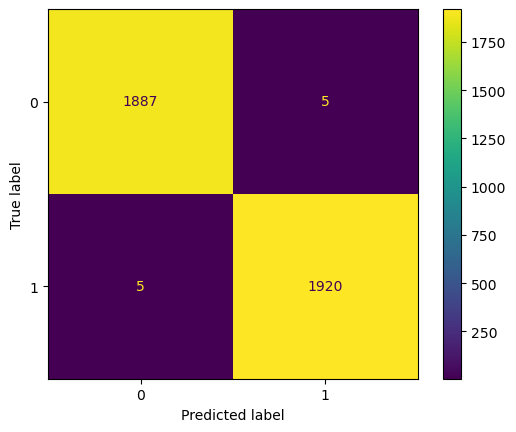

In [82]:
#Creating a confusion matrix to visualize the results of the classification model

#Compute the values for confusion matrix
log_cm = confusion_matrix(y_val,y_pred)

#Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

#Plot confusion matrix
log_disp.plot()

#Display plot
plt.show()

In [83]:
#Creating a classification report for random forest model
target_labels = ['opinion','claim']
print(classification_report(y_val,y_pred, target_names=target_labels))


              precision    recall  f1-score   support

     opinion       1.00      1.00      1.00      1892
       claim       1.00      1.00      1.00      1925

    accuracy                           1.00      3817
   macro avg       1.00      1.00      1.00      3817
weighted avg       1.00      1.00      1.00      3817



In [85]:
#Evaluate model against validation data
y_pred = xgb_cv.best_estimator_.predict(X_val_final)

#Display the predictions on the validation set
y_pred

array([1, 0, 1, ..., 1, 1, 1])

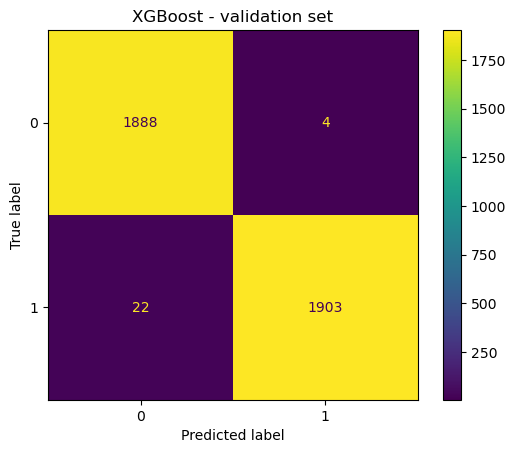

In [86]:
#Creating a confusion matrix to visualize the results of the classification model

#Compute the values for confusion matrix
log_cm = confusion_matrix(y_val,y_pred)

#Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

#Plot confusion matrix
log_disp.plot()

#Display plot
plt.title('XGBoost - validation set')
plt.show()

In [87]:
#Creating a classification report for random forest model
target_labels = ['opinion','claim']
print(classification_report(y_val,y_pred, target_names=target_labels))

              precision    recall  f1-score   support

     opinion       0.99      1.00      0.99      1892
       claim       1.00      0.99      0.99      1925

    accuracy                           0.99      3817
   macro avg       0.99      0.99      0.99      3817
weighted avg       0.99      0.99      0.99      3817



In [88]:
#Evaluate model against validation data
y_pred = rf_cv.best_estimator_.predict(X_test_final)

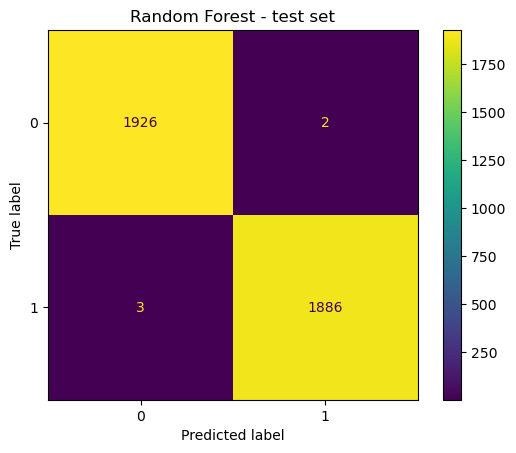

In [89]:
#Compute the values for confusion matrix
log_cm = confusion_matrix(y_test,y_pred)

#Creating display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm, display_labels=None)

#Plot confusion matrix
log_disp.plot()

#Display plot
plt.title('Random Forest - test set');
plt.show()

Feature importances of the champion model

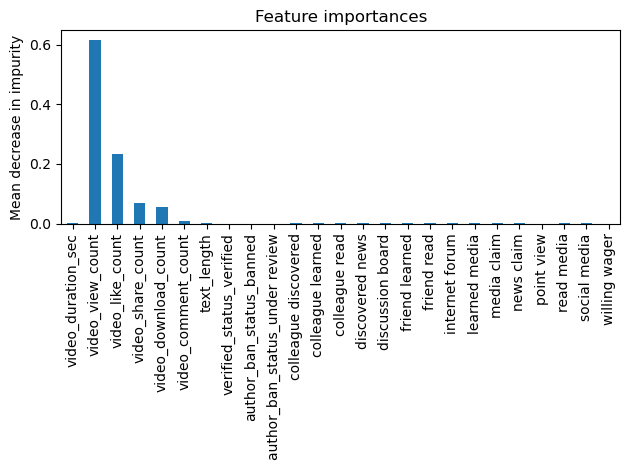

In [91]:
importances = rf_cv.best_estimator_.feature_importances_
rf_importances = pd.Series(importances, index=X_test_final.columns)

fig, ax = plt.subplots()
rf_importances.plot.bar(ax=ax)
ax.set_title('Feature importances')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()


### Conclusion

. Random Forest model performs very well, with a average recall score of 0.995.

. XGBoost recall score is slightly lower compare to random forest though it has perfect precision score.

. Confusion matrix indicates that, there were only 10 misclassifications in random forest model than XGBoost which had       more.

. Considering business objectives of model that can identifies claims, XGBoost is not reliable since it errors tends 
  to more false negatives.
  
. Random Forest was chosen as champion though model architectures of both almost produced perfect models,
  but it recall score was better.
  
. The champion model performance on the test holdout data yielded near perfect scores, with only 5 misclassified samples     out of 3,817.